### Inferencia
En este notebook vamos a realizar la inferencia sobre los dataset de Covid-19 en Colombia y además como caso especifico en Santander un departamento de colombia, usaremos los modelos destilados que entrenamos previamente en los notebooks de Main_neural y Main.

### Santander

In [1]:
import numpy as np
# Importing custom functions
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

from baseline.functions import load_data,create_intervals,create_windows,smape,smape_chunked,sample_fraction
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def create_windows_2(data, window_size=15, horizon=1):
    """
    Crea ventanas deslizantes (X, y) a partir de:
      - data: puede ser
          * un numpy array 1D (una sola serie temporal), o
          * una lista/iterable de numpy arrays 1D (varias series).
    Parámetros:
      - window_size: número de pasos de entrada por ventana X
      - horizon: pasos a predecir (por defecto 1)
    Devuelve:
      - X: array de shape (num_samples, window_size, 1)
      - y: array de shape (num_samples,) si horizon=1,
             o (num_samples, horizon) en otro caso.
    """
    # Si data es un array 1D, lo convertimos en lista de una sola secuencia
    if isinstance(data, np.ndarray) and data.ndim == 1:
        sequences = [data]
    else:
        # Asumimos que data es iterable de arrays 1D
        sequences = [np.asarray(seq).astype(float) for seq in data]

    X_list, y_list = [], []

    for arr in sequences:
        T = arr.shape[0]
        # Solo procesar si hay suficiente longitud
        if T >= window_size + horizon:
            for start in range(T - window_size - horizon + 1):
                window = arr[start : start + window_size]
                target = arr[start + window_size : start + window_size + horizon]
                X_list.append(window.reshape(window_size, 1))
                # Si horizon=1 devolvemos escalar, si no, el vector entero
                y_list.append(target[0] if horizon == 1 else target)

    # Si no se creó ninguna muestra, devolvemos arrays vacíos con las formas correctas
    if not X_list:
        X = np.empty((0, window_size, 1))
        y = np.empty((0,)) if horizon == 1 else np.empty((0, horizon))
        return X, y

    X = np.stack(X_list, axis=0)
    y = np.array(y_list)

    # Filtrar muestras que contengan NaN en X o en y
    mask_valid = ~np.isnan(X).any(axis=(1,2))
    if horizon == 1:
        mask_valid &= ~np.isnan(y)
    else:
        mask_valid &= ~np.isnan(y).any(axis=1)

    X_clean = X[mask_valid]
    y_clean = y[mask_valid]

    print(f"De {X.shape[0]} muestras, quedan {X_clean.shape[0]} sin NaN")
    return X_clean, y_clean

In [2]:
data = load_data('serie.csv')
serie= data['Frecuencia'].values
X, y  = create_windows_2(serie)

De 1114 muestras, quedan 1114 sin NaN


In [3]:
# load models
import torch
import torch.nn as nn
from torchdiffeq import odeint
import tensorflow as tf

In [4]:
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, x):
        return self.net(x)

class NeuralODEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = ODEFunc()
    
    def forward(self, x):
        # x: [batch_size, seq_len, features]
        device = x.device
        seq_len = x.shape[1]
        # Crear t en el dispositivo correcto
        t = torch.linspace(0, 1, seq_len, device=device)
        # Estado inicial para cada muestra: último valor de la secuencia
        # Si features=1, x[:, -1, :] es [batch_size, 1]
        y0 = x[:, -1, :]
        # Integrar en batch: devuelve [len(t), batch_size, features]
        out = odeint(self.odefunc, y0, t, method='rk4')
        # Tomar el valor final en t=1 para cada muestra
        y_final = out[-1]
        return y_final  # forma [batch_size, features]
    
# 1. Carga el checkpoint completo
checkpoint = torch.load("Models_neural/modelo_3_dest.pth", map_location="cpu")

# 2. Filtra y renombra solo los pesos de 'backbone'
new_state_dict = {}
for k, v in checkpoint.items():
    if k.startswith("backbone.odefunc."):
        # elimino el prefijo "backbone."
        new_key = k.replace("backbone.", "")
        new_state_dict[new_key] = v


# 3. Crea tu modelo y carga con strict=False para ignorar lo que falte
ode_model = NeuralODEModel()
missing, unexpected = ode_model.load_state_dict(new_state_dict, strict=False)
ode_model.eval()


NeuralODEModel(
  (odefunc): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense

@tf.keras.utils.register_keras_serializable(package="CustomModels")
class StudentTOR(Model):
    def __init__(
        self,
        window_size: int,
        n_features: int,
        lstm_units: int,
        epsilon: float,
        c_tor: float = 1.0,
        c_dist: float = 1.0,
        **kwargs
    ):
        super().__init__(**kwargs)
        # Guardamos los hiperparámetros para serializar
        self.window_size = window_size
        self.n_features  = n_features
        self.lstm_units  = lstm_units
        self.epsilon     = epsilon
        self.c_tor       = c_tor
        self.c_dist      = c_dist

        self.lstm = LSTM(
            lstm_units,
            input_shape=(window_size, n_features),
            name="lstm_layer"
        )
        self.dense_clean   = Dense(1, name="clean_output")
        self.dense_teacher = Dense(1, name="teacher_output")

    def call(self, inputs, training=False):
        x = self.lstm(inputs)
        return self.dense_clean(x), self.dense_teacher(x)

    def compute_tor_loss(self, t, r_t_gt, Rs):
        err = tf.abs(t - r_t_gt)
        clean_loss   = tf.square(Rs - t)
        outlier_loss = tf.sqrt(tf.square(Rs - r_t_gt) + 1e-6)
        return tf.where(err < self.epsilon, clean_loss, outlier_loss)

    def train_step(self, data):
        x, y = data
        t      = y[:, 0:1]   # etiqueta real
        r_t_gt = y[:, 1:2]   # pred teacher

        with tf.GradientTape() as tape:
            Rs, Rd = self(x, training=True)
            L_tor  = tf.reduce_mean(self.compute_tor_loss(t, r_t_gt, Rs))
            L_dist = tf.reduce_mean(tf.abs(Rd - r_t_gt))
            loss   = self.c_tor * L_tor + self.c_dist * L_dist

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(t, Rs)
        return {
            "loss": loss,
            "tor_loss": L_tor,
            "distill_loss": L_dist,
            **{m.name: m.result() for m in self.metrics}
        }

    def test_step(self, data):
        x, y = data
        t      = y[:, 0:1]
        r_t_gt = y[:, 1:2]
        Rs, Rd = self(x, training=False)

        L_tor  = tf.reduce_mean(self.compute_tor_loss(t, r_t_gt, Rs))
        L_dist = tf.reduce_mean(tf.abs(Rd - r_t_gt))
        loss   = self.c_tor * L_tor + self.c_dist * L_dist

        self.compiled_metrics.update_state(t, Rs)
        return {
            "loss": loss,
            "tor_loss": L_tor,
            "distill_loss": L_dist,
            **{m.name: m.result() for m in self.metrics}
        }

    def get_config(self):
        # Devuelve todo lo necesario para reconstruir la instancia
        base_config = super().get_config()
        return {
            **base_config,
            "window_size": self.window_size,
            "n_features":  self.n_features,
            "lstm_units":  self.lstm_units,
            "epsilon":     self.epsilon,
            "c_tor":       self.c_tor,
            "c_dist":      self.c_dist,
        }

    @classmethod
    def from_config(cls, config):
        # Separar kwargs de Model (si los hubiera)
        return cls(
            window_size=config.pop("window_size"),
            n_features=config.pop("n_features"),
            lstm_units=config.pop("lstm_units"),
            epsilon=config.pop("epsilon"),
            c_tor=config.pop("c_tor"),
            c_dist=config.pop("c_dist"),
            **config
        )

lstm_model = tf.keras.models.load_model(
    "Models_lstm/lstm_healthcare_model_3_destilation.keras",
    compile=False
)
lstm_model.summary()

c:\Users\criju\.conda\envs\ts\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "student_tor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer (LSTM)               │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clean_output (Dense)            │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ teacher_output (Dense)          │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,502 (41.02 KB)

 Trainable params: 10,502 (41.02 KB)

 Non-trainable params: 0 (0.00 B)

## Resultados modelo neuralODE sobre test

In [18]:
ode_model.eval()
pred = ode_model(torch.tensor(X, dtype=torch.float32))
# Rd_pred es tu salida distill, compárala con y_val:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, pred.cpu().detach().numpy())
mae = mean_absolute_error(y, pred.cpu().detach().numpy())
smape_val = smape(y, pred.cpu().detach().numpy())

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 52.43295911965721
MSE: 13662.251021643615
SMAPE: 67.07636250761472


## Resultados modelo LSTM sobre test

In [12]:
Rs_output, Rd_output = lstm_model.predict(X)

#Resultados de modelos teacher sobre el conjunto de validación 
mae = mean_absolute_error(y, Rd_output)
mse = mean_squared_error(y, Rd_output)
smape_val = smape(y, Rd_output)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 261.9834539555983
MSE: 251683.1183891016
SMAPE: 77.5627587205362


## Resultados modelo timesMOE sobre test

In [8]:
# Modelo teacher
# Teacher prediction using Time-MoE
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map="cpu",  # use "cpu" for CPU inference, and "cuda" for GPU inference.
    trust_remote_code=True,
)

# Convertir las ventanas a tensores para el modelo Time-MoE
import torch
import numpy as np    

train_predict_teacher = []
for arr in X:                   
    t = torch.from_numpy(arr.reshape(1, 15)).float()  
    mean = t.mean(dim=-1, keepdim=True)   # (1,1)
    std  = t.std(dim=-1, keepdim=True)    # (1,1)
    std = std.clamp(min=1e-6) # Evitar división por cero
    normed_seq = (t - mean) / std         # (1,15)
    output = model.generate(normed_seq, max_new_tokens=1)  
    normed_pred = output[:, -1:]            # (1,1)
    pred = normed_pred * std + mean         # (1,1)
    train_predict_teacher.append(pred.item())

C:\Users\criju\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0723 17:26:35.198000 29772 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
C:\Users\criju\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
#pred_t = np.vstack([t.cpu().numpy().reshape(-1,1) for t in train_predict_teacher])
pred_t = train_predict_teacher

In [10]:
#Resultados de modelos teacher sobre el conjunto de validación 
mae = mean_absolute_error(y, pred_t)
mse = mean_squared_error(y, pred_t)
smape_val = smape(y, pred_t)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 52.6560321574499
MSE: 13234.54632603063
SMAPE: 17.427596961401246


In [19]:
pred

tensor([[ 1.7993],
        [ 0.4974],
        [ 4.4820],
        ...,
        [ 5.7136],
        [ 9.0200],
        [10.0657]], grad_fn=<SelectBackward0>)

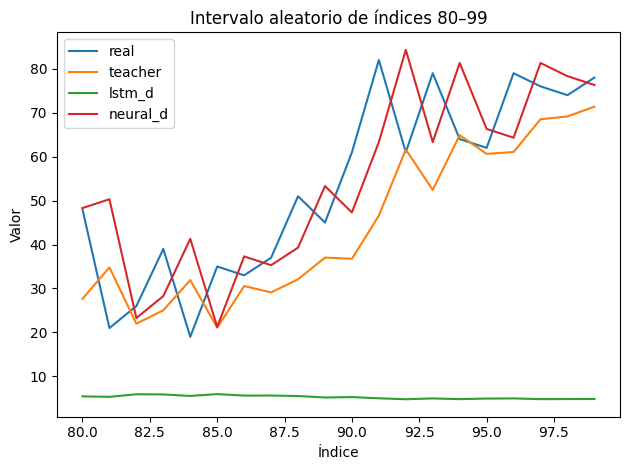

In [22]:
# Graficas de comparación
import random
import matplotlib.pyplot as plt

# Tus listas originales:
# y_val, r_t_val, Rd_output

# Asegúrate de que todas tengan la misma longitud n ≥ 20
n = len(y)

# Elige un índice de inicio aleatorio tal que haya espacio para 20 puntos
inicio = random.randint(0, n - 20)
fin = inicio + 20

# Crea un eje X con los índices reales para ese intervalo
x = list(range(inicio, fin))

# Extrae los subrangos de cada serie
y_segmento     = y[inicio:fin]
teacher_segmento = pred_t[inicio:fin]
destilado_lstm =  Rd_output[inicio:fin]
destulado_neural =  pred.cpu().detach().numpy()[inicio:fin]

# Grafica solo el intervalo seleccionado
plt.figure()
plt.plot(x, y_segmento,         label='real')
plt.plot(x, teacher_segmento,   label='teacher')
plt.plot(x, destilado_lstm, label='lstm_d')
plt.plot(x, destulado_neural, label='neural_d')

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title(f'Intervalo aleatorio de índices {inicio}–{fin-1}')
plt.legend()
plt.tight_layout()
plt.show()


### Colombia

In [40]:
data = load_data('serie_completa.csv')
serie= data['Frecuencia'].values
X, y  = create_windows_2(serie)

De 1404 muestras, quedan 1404 sin NaN


In [41]:
# Neural ODE Model


ode_model.eval()
pred = ode_model(torch.tensor(X, dtype=torch.float32))
# Rd_pred es tu salida distill, compárala con y_val:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, pred.cpu().detach().numpy())
mae = mean_absolute_error(y, pred.cpu().detach().numpy())
smape_val = smape(y, pred.cpu().detach().numpy())

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 496.1793212890625
MSE: 1127681.625
SMAPE: 67.01675281368486


In [42]:
# LSTM Model
Rs_output, Rd_output = lstm_model.predict(X)

#Resultados de modelos teacher sobre el conjunto de validación 
mae = mean_absolute_error(y, Rd_output)
mse = mean_squared_error(y, Rd_output)
smape_val = smape(y, Rd_output)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 4187.7734375
MSE: 57807716.0
SMAPE: 95.5458926452555


In [43]:
# Teacher prediction using Time-MoE

# Convertir las ventanas a tensores para el modelo Time-MoE
import torch
import numpy as np    

tensors = []
for arr in X:                   
    t = torch.from_numpy(arr.reshape(1, 15)).float()  
    tensors.append(t)

train_predict_teacher = []
for i in range(len(tensors)):
    output = model.generate(tensors[i], max_new_tokens=1)  # shape is [batch_size, 12 + 6]
    normed_predictions = output[:, -1:]  
    train_predict_teacher.append(normed_predictions)

pred_t = np.vstack([t.cpu().numpy().reshape(-1,1) for t in train_predict_teacher])

In [44]:
#Resultados de modelos teacher sobre el conjunto de validación 
mae = mean_absolute_error(y, pred_t)
mse = mean_squared_error(y, pred_t)
smape_val = smape(y, pred_t)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 4186.66162109375
MSE: 57833512.0
SMAPE: 95.07393782492657


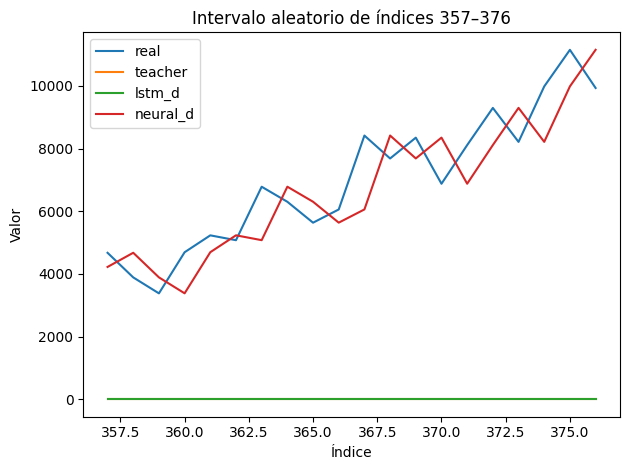

In [ ]:
import random
import matplotlib.pyplot as plt

# Tus listas originales:
# y_val, r_t_val, Rd_output

# Asegúrate de que todas tengan la misma longitud n ≥ 20
n = len(y)

# Elige un índice de inicio aleatorio tal que haya espacio para 20 puntos
inicio = random.randint(0, n - 20)
fin = inicio + 20

# Crea un eje X con los índices reales para ese intervalo
x = list(range(inicio, fin))

# Extrae los subrangos de cada serie
y_segmento = y[inicio:fin]
teacher_segmento = pred_t[inicio:fin]
destilado_lstm =  Rd_output[inicio:fin]
destulado_neural =  pred.cpu().detach().numpy()[inicio:fin]

# Grafica solo el intervalo seleccionado
plt.figure()
plt.plot(x, y_segmento,         label='real')
plt.plot(x, teacher_segmento,   label='teacher')
plt.plot(x, destilado_lstm, label='lstm_d')
plt.plot(x, destulado_neural, label='neural_d')

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title(f'Intervalo aleatorio de índices {inicio}–{fin-1}')
plt.legend()
plt.tight_layout()
plt.show()


### Prueba con otros dataset